<a href="https://www.kaggle.com/code/sharanharsoor/gensim-word2vec-countires-wiki?scriptVersionId=125052978" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
In this notebook we will analyse word2ved for countires wikipedia page.

In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.layers import Embedding
# imports

import json
from collections import Counter
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import json

%matplotlib inline

# Basic Analysis of Data

In [2]:
class MetricCallback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self, every=10):
        self.myloss = []
        self.epoch = 0
        self.every = every

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            self.myloss.append(loss)
        else:
            self.myloss.append(loss - self.loss_previous_step)
        if self.epoch % self.every == 0:
            print(f'Loss after epoch {self.epoch}: {self.myloss[-1]}')  # NOQA: T001
        self.epoch += 1
        self.loss_previous_step = loss


def plot_arrows(starts, ends, wv, estimator=PCA, **kwargs):
    if len(starts) != len(ends):
        raise ValueError('starts and ends must be the same length.')
    fig, ax = plt.subplots(figsize=kwargs.pop('figsize', (8, 8)))
    X = wv[starts + ends]  # NOQA: N806
    x_red = estimator(n_components=2).fit_transform(X)
    plt.scatter(*x_red.T)
    for i, word in enumerate(starts + ends):
        plt.annotate(word, x_red[i])
    xstart = x_red[:len(starts)]
    xend = x_red[len(starts):]
    for i, (start, end) in enumerate(zip(starts, ends)):
        x1, y1 = xstart[i]
        x2, y2 = xend[i]
        plt.arrow(x1, y1, x2 - x1, y2 - y1)


def plot_vectors(words, model, estimator=TSNE, **kwargs):
    names = []
    vectors = []
    for word in words:
        if word in model.wv:
            names.append(word)
            vectors.append(model.wv[word])

    X = np.r_[vectors]  # NOQA: N806
    x_red = estimator(n_components=2).fit_transform(X)
    fig, ax = plt.subplots(figsize=kwargs.pop('figsize', (16, 16)))  # NOQA: E912
    ax.scatter(*x_red.T)

    for i, word in enumerate(names):
        plt.annotate(word, x_red[i])


def make_embedding_layer(model, tokenizer, MAX_SEQUENCE_LENGTH):  # NOQA: N803
    word_index = tokenizer.word_index
    if isinstance(model, Word2Vec):
        wv = model.wv
    elif isinstance(model, KeyedVectors):
        wv = model
    embedding_matrix = np.zeros((len(word_index) + 1, wv.vector_size))
    for word, i in word_index.items():
        try:
            vector = wv.get_vector(word, False)
            embedding_matrix[i] = vector
        except KeyError:
            continue
    el = Embedding(
        len(word_index) + 1, wv.vector_size, weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH, trainable=False
    )
    return el


In [3]:
file_path = '/kaggle/input/countries-with-wikipedia-content/countries.json'
with open(file_path, 'r') as file:
    file_content = file.read()

# Load the JSON data from the file content
countries = json.loads(file_content)

In [4]:
countries['India'][:20]

['India',
 'Hindi',
 'Bhārat',
 'officially',
 'the',
 'Republic',
 'of',
 'India',
 'Hindi',
 'Bhārat',
 'Gaṇarājya',
 'is',
 'a',
 'country',
 'in',
 'South',
 'Asia',
 'It',
 'is',
 'the']

In [5]:
print(' '.join(countries['India'])[:512] + ' ...')

India Hindi Bhārat officially the Republic of India Hindi Bhārat Gaṇarājya is a country in South Asia It is the second most populous country the seventh largest country by land area and the most populous democracy in the world Bounded by the Indian Ocean on the south the Arabian Sea on the southwest and the Bay of Bengal on the southeast it shares land borders with Pakistan to the west China Nepal and Bhutan to the north and Bangladesh and Myanmar to the east In the Indian Ocean India is in the vicinity of  ...


In [6]:
for i, (country, text) in enumerate(countries.items()):
    print(country)
    print(' '.join(text)[:512] + ' ...')
    print('-' * 100)
    if i >= 5:
        break

Afghanistan
Afghanistan listen Pashto Dari افغانستان Pashto Afġānistān avɣɒnisˈtɒn ab Dari Afġānestān avɣɒnesˈtɒn officially the Islamic Republic of Afghanistan is a mountainous landlocked country at the crossroads of Central and South Asia Afghanistan is bordered by Pakistan to the east and south Iran to the west Turkmenistan Uzbekistan and Tajikistan to the north and China to the northeast Occupying 652 000 square kilometers 252 000 sq mi it is a mountainous country with plains in the north and southwest Kabul is the ...
----------------------------------------------------------------------------------------------------
Albania
Albania listen a w l BAY nee ə Albanian Shqipëri or Shqipëria officially the Republic of Albania Albanian Republika e Shqipërisë is a country in Southeastern Europe It is located on the Adriatic and Ionian Sea within the Mediterranean Sea and shares land borders with Montenegro to the northwest Kosovo to the northeast North Macedonia to the east Greece to the 

# Basic Word2Vec Usage

In [7]:
# Create and train a simple model

model = Word2Vec(sentences=countries.values())

In [8]:
# Check word similarities learnt by the model

model.wv.most_similar('India', topn=5)

[('Brazil', 0.831546425819397),
 ('Iran', 0.7901660203933716),
 ('China', 0.7867245078086853),
 ('Arabia', 0.7754247784614563),
 ('Mozambique', 0.7682541012763977)]

In [9]:
# Enable computation of loss

model = Word2Vec(
    sentences=countries.values(),
    compute_loss=True
)
model.get_latest_training_loss()

5395566.5

# Heuristics for Word2vec algorithms

In [10]:
# How many unique words in the vocabulary?

counter = Counter()
for words in countries.values():
    for word in words:
        counter.update([word])

print(len(counter))

85125


In [11]:
# Default vocabulary size of the original model
print(len(model.wv.index_to_key))

21092


Loss after epoch 0: 1409759.375
Loss after epoch 1: 1153271.875
Loss after epoch 2: 1025085.25
Loss after epoch 3: 891057.5
Loss after epoch 4: 803154.5


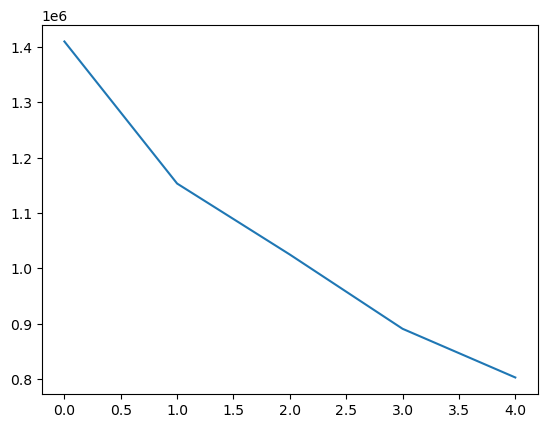

In [12]:
# Retrain - increased vocabulary size, more epochs, larger word vectors
# Note: Here MetricCallback is directly called as there is no utils package here.

metric = MetricCallback(every=1)
model = Word2Vec(
    sentences=countries.values(),
    vector_size=128,
    max_vocab_size=65536,
    compute_loss=True,
    callbacks=[metric]
)
plt.plot(metric.myloss)

In [13]:
# Check similarities again

model.wv.most_similar('India')

[('Brazil', 0.8292582035064697),
 ('China', 0.8091830611228943),
 ('Iran', 0.7880387306213379),
 ('Arabia', 0.7682465314865112),
 ('Laos', 0.7680453062057495),
 ('Turkey', 0.7614400386810303),
 ('Mozambique', 0.750378429889679),
 ('Ethiopia', 0.7425389289855957),
 ('Vietnam', 0.7416154742240906),
 ('Russia', 0.7376955151557922)]

Loss after epoch 0: 474219.8125
Loss after epoch 1: 373776.6875
Loss after epoch 2: 324982.375
Loss after epoch 3: 309179.75
Loss after epoch 4: 284448.375
Loss after epoch 5: 302404.75
Loss after epoch 6: 308385.25
Loss after epoch 7: 266005.75
Loss after epoch 8: 269088.5
Loss after epoch 9: 237775.0


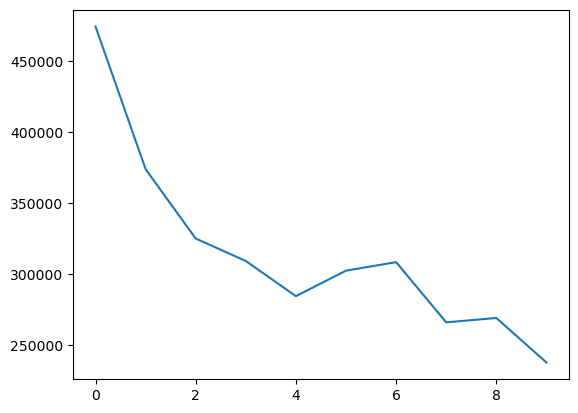

In [14]:
# Retrain - more epochs
# Note: Here MetricCallback is directly called as there is no utils package here.

metric = MetricCallback(every=1)
model = Word2Vec(
    sentences=countries.values(),
    vector_size=128,
    max_vocab_size=65536,
    compute_loss=True,
    callbacks=[metric],
    epochs = 10,
    min_alpha=0.001,
    workers=9
)
plt.plot(metric.myloss)

In [15]:
model.wv.most_similar('India')

[('China', 0.6989285349845886),
 ('Pakistan', 0.6432790756225586),
 ('Vietnam', 0.5942493677139282),
 ('Asia', 0.5774434804916382),
 ('Nepal', 0.5624611973762512),
 ('Iran', 0.5564058423042297),
 ('Korea', 0.5474463105201721),
 ('East', 0.5456535220146179),
 ('Thailand', 0.5443084239959717),
 ('Egypt', 0.5418037176132202)]

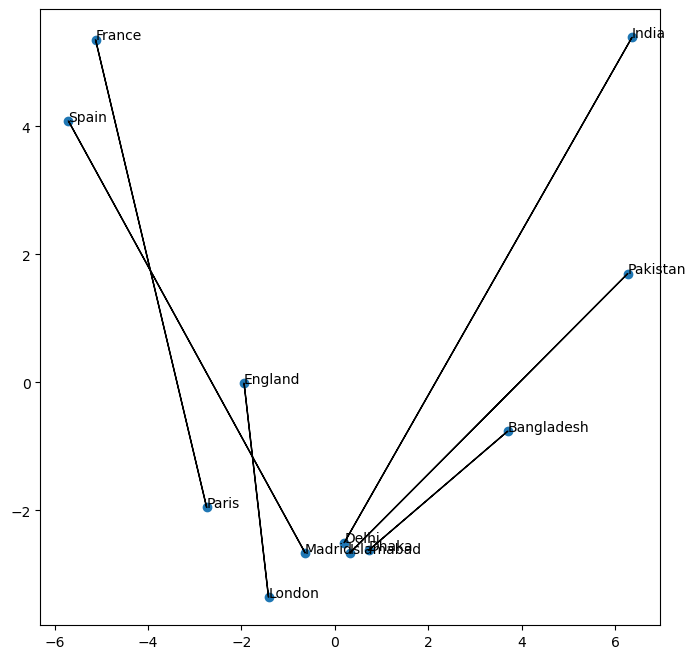

In [16]:
# Examine the vector space

X = ['India', 'Pakistan', 'Bangladesh', 'France', 'England', 'Spain']
Y = ['Delhi', 'Islamabad', 'Dhaka', 'Paris', 'London', 'Madrid']
plot_arrows(X, Y, model.wv)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


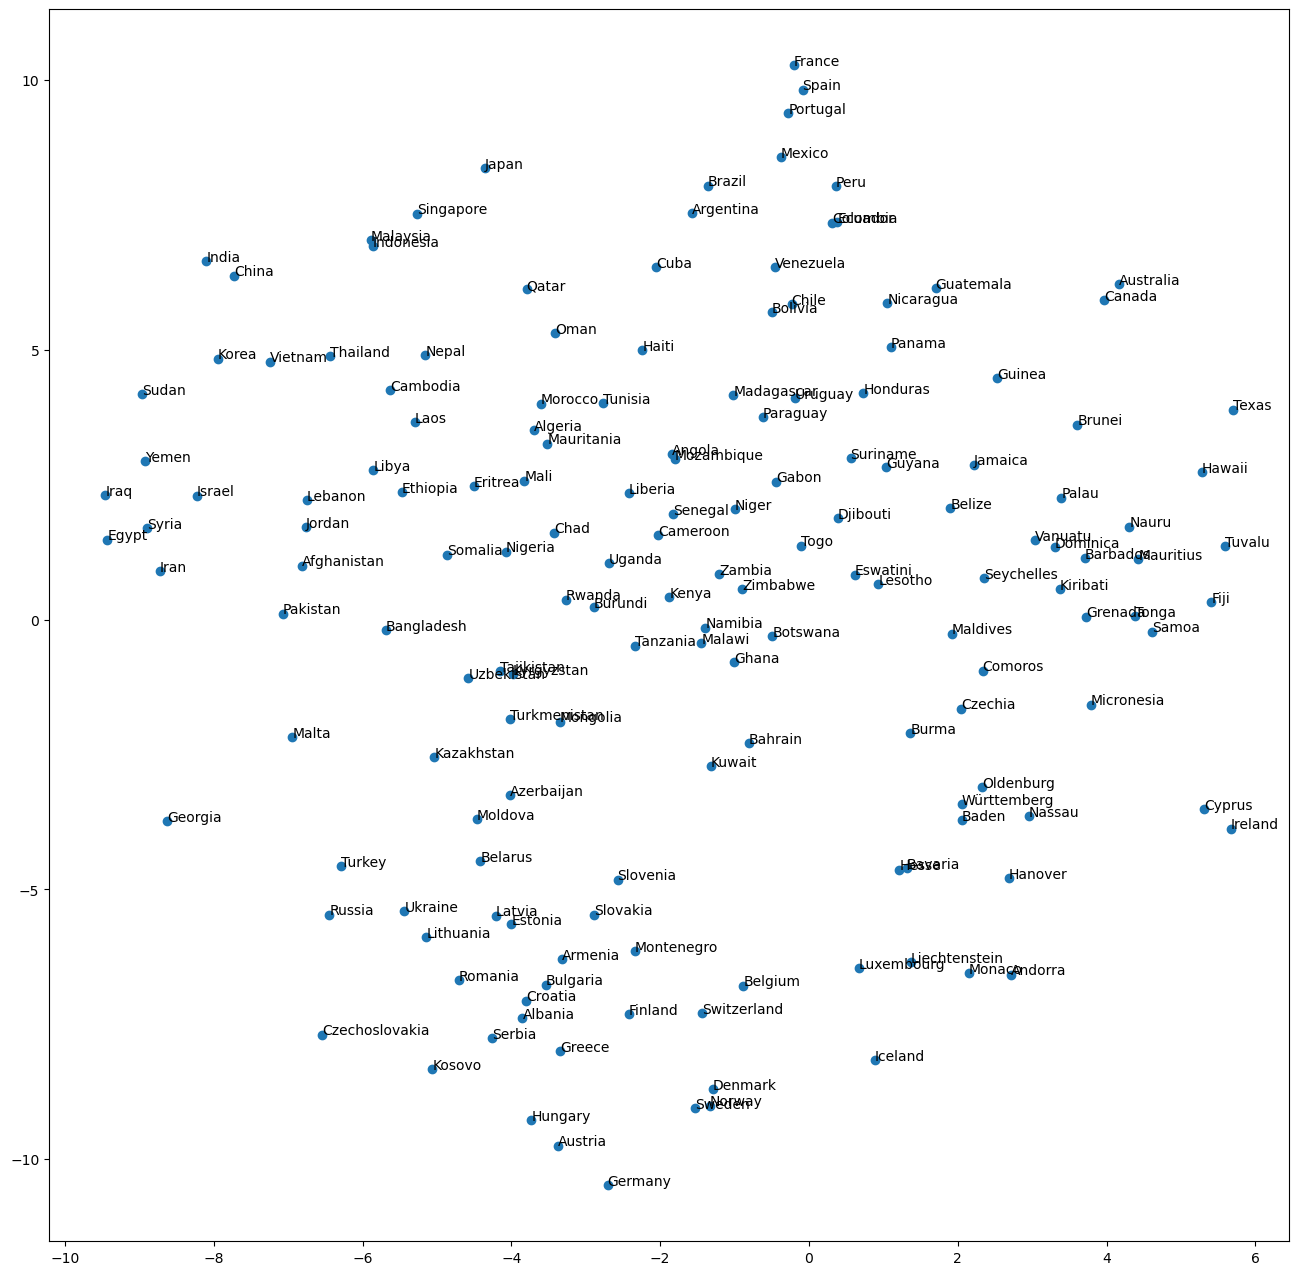

In [17]:
# Visualize vectors for all countries

plot_vectors(countries, model)

# Word Analogies

In [18]:
# India: Ganges -> Brazil: __ ?

model.wv.most_similar(positive=['Ganges', 'Brazil'], negative=['India'])

[('Lempa', 0.6460702419281006),
 ('Napo', 0.6451288461685181),
 ('Leine', 0.6318599581718445),
 ('Reservoir', 0.6295623779296875),
 ('Sanaga', 0.6293299794197083),
 ('Grande', 0.6269009113311768),
 ('Maracaibo', 0.6259864568710327),
 ('Tonle', 0.6259410977363586),
 ('Enriquillo', 0.625253438949585),
 ('Falls', 0.6231862902641296)]

In [19]:
# America: Washington -> France: __ ?

model.wv.most_similar(positive=['Washington', 'France'], negative=['America'])

[('1899', 0.5823708176612854),
 ('Accords', 0.5619364380836487),
 ('Paris', 0.558577299118042),
 ('Mission', 0.5496121644973755),
 ('Operation', 0.5457298755645752),
 ('Charles', 0.5440526008605957),
 ('UK', 0.5407190322875977),
 ('1810', 0.5404533743858337),
 ('Taylor', 0.5400722026824951),
 ('1814', 0.53643798828125)]

In [20]:
# India: Hindi -> Germany: __ ?

model.wv.most_similar(positive=['Hindi', 'Germany'], negative=['India'])

[('German', 0.588809072971344),
 ('Afrikaans', 0.5827357172966003),
 ('Hessen', 0.5667898058891296),
 ('Bayern', 0.5633697509765625),
 ('Stato', 0.562381386756897),
 ('Österreich', 0.5570935010910034),
 ('Communion', 0.556639552116394),
 ('မ', 0.5544089078903198),
 ('Péter', 0.5489193201065063),
 ('della', 0.548736572265625)]

In [21]:
# Save the model

model.save('wiki-countries.w2v')

In [22]:
from gensim.models import KeyedVectors
model = KeyedVectors.load('wiki-countries.w2v')

In [23]:
model

# END